<h1 style="text-align: center; font-weight: bold;"><u>Import et chargement des données</u></h1>

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
from collections import Counter
from nltk.tokenize import word_tokenize
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
from mesFonctions import (
    tokenize_english_descriptions,
    afficher_tokens,
    get_word_frequencies,
    plot_word_frequencies,
    get_word_frequencies_filtered,
    get_word_frequencies_lemmatized,
    get_lemmatized_frequencies_by_description,
    plot_bow_heatmap,
    apply_tfidf,
    plot_top_tfidf_words,
    reduce_tsne,
    cluster_kmeans,
    plot_tsne,
    extract_unique_categories,
    extract_category,
    vectorize_text,
    plot_2D_clusters,
    use_vectorize,
    bert_vectorize,
    generate_wordclouds_by_category_with_extraction,
    reduce_tsne_bert_use,
    get_image_size,
    reduce_pca,
    find_best_k,
    full_clustering_pipeline,
    filter_stopwords_from_text,
    add_filtered_tokens_column,
    afficher_tokens_supprimes,
    stem_tokens_column,
    afficher_exemple_stem,
    reduce_tsne2,
    is_low_contrast,
    plot_image_and_histogram,
    apply_contrast_clahe,
    equalize_hist_color,
    rotate_image,
    equalize_with_pil,
    equalize_with_cv2,
    plot_gray_image_and_histogram,
    evaluate_model_2,
    run_all_methods2,
    run_all_methods,
    prepare_dataframe,
    create_data_generators,
    train_and_evaluate_model
)
import os
from nltk.data import path as nltk_data_path
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score
import gensim
from gensim.models import Word2Vec
from wordcloud import WordCloud
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime
import time
import csv
import cv2

from tqdm.notebook import tqdm
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2

from transformers import BertModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")


from PIL import Image, ImageOps

logs = []

In [11]:
# Paramètres globaux
IMAGE_DIR = "data/images"
filename = "55b85ea15a1536d46b7190ad6fff8ce7.jpg"
image_path = os.path.join(IMAGE_DIR, filename)
# Dossier contenant les images
CSV_PATH = "data/flipkart_com-ecommerce_sample_1050.csv"     # Ton fichier CSV
IMAGE_SIZE = (224, 224)       # Pour ResNet50
N_CLUSTERS = 7
RANDOM_STATE = 42


In [12]:
# Chargement du DataFrame
df = pd.read_csv(CSV_PATH)

# Affichage d’un échantillon
df.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

In [13]:
# Construction du chemin complet vers les images
df['image_path'] = df['image'].apply(lambda x: os.path.join(IMAGE_DIR, x))


In [14]:
df_categories = extract_unique_categories(df)
print(df_categories["extracted_category"])

0               Home Furnishing
1                     Baby Care
2                       Watches
3    Home Decor & Festive Needs
4              Kitchen & Dining
5      Beauty and Personal Care
6                     Computers
Name: extracted_category, dtype: object


In [15]:
df["extracted_category"] = df["product_category_tree"].apply(extract_category)
print(df["extracted_category"])

0       Home Furnishing
1             Baby Care
2             Baby Care
3       Home Furnishing
4       Home Furnishing
             ...       
1045          Baby Care
1046          Baby Care
1047          Baby Care
1048          Baby Care
1049          Baby Care
Name: extracted_category, Length: 1050, dtype: object


In [16]:
df_filtered = df[["extracted_category", "image"]]
print(df_filtered.head())  # ou simplement df_filtered

  extracted_category                                 image
0    Home Furnishing  55b85ea15a1536d46b7190ad6fff8ce7.jpg
1          Baby Care  7b72c92c2f6c40268628ec5f14c6d590.jpg
2          Baby Care  64d5d4a258243731dc7bbb1eef49ad74.jpg
3    Home Furnishing  d4684dcdc759dd9cdf41504698d737d8.jpg
4    Home Furnishing  6325b6870c54cd47be6ebfbffa620ec7.jpg


<h1 style="text-align: center; font-weight: bold;"><u>1/ Analyse des images</u></h1>

<h2 style="text-align: left; font-weight: bold;"><u>Prétraitement</u></h2>

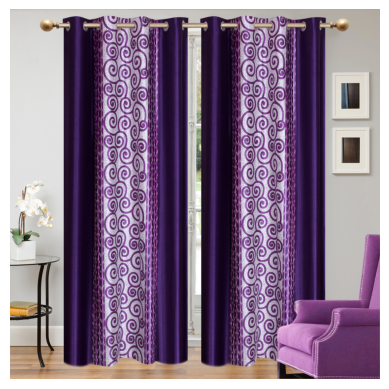

In [31]:
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir BGR (OpenCV) → RGB (matplotlib)

plt.imshow(img_rgb)
plt.axis('off')  # Supprime les axes
plt.show()

In [32]:
# Récupérer les dimensions
height, width, channels = img.shape

print(f"Largeur : {width} px")
print(f"Hauteur : {height} px")
print(f"Canaux : {channels}")

Largeur : 3600 px
Hauteur : 3600 px
Canaux : 3


In [33]:
x, y = 100, 50  # Position (colonne, ligne)

intensite = img[y, x]  # Attention : (ligne, colonne)
print(f"Valeur du pixel à ({x}, {y}) : {intensite}")

Valeur du pixel à (100, 50) : [205 209 210]


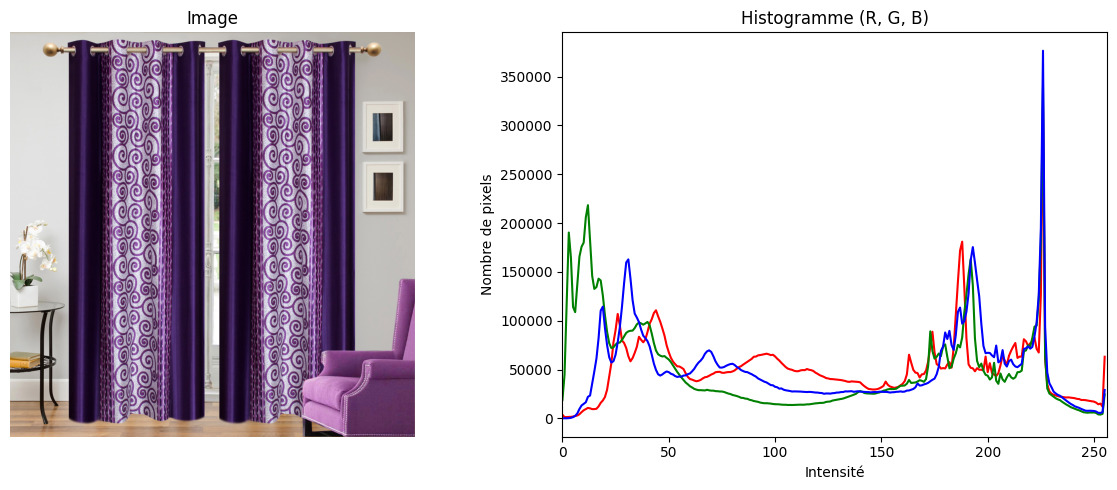

In [34]:
# Créer une figure avec 1 ligne et 2 colonnes
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Affichage de l'image
axs[0].imshow(img_rgb)
axs[0].axis('off')
axs[0].set_title("Image")

# Calcul et affichage de l'histogramme (pour chaque canal R, G, B)
colors = ('r', 'g', 'b')
for i, color in enumerate(colors):
    hist = cv2.calcHist([img], [i], None, [256], [0, 256])
    axs[1].plot(hist, color=color)
    axs[1].set_xlim([0, 256])

axs[1].set_title("Histogramme (R, G, B)")
axs[1].set_xlabel("Intensité")
axs[1].set_ylabel("Nombre de pixels")

plt.tight_layout()
plt.show()


<h2 style="text-align: left; font-weight: bold;"><u>Étirement d’histogrammes</u></h2>

In [35]:
# 📋 Liste des images compressées
compressed_images = []

# 🔁 Parcourir les fichiers du dossier
for filename in os.listdir(IMAGE_DIR):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
        path = os.path.join(IMAGE_DIR, filename)
        img = cv2.imread(path)
        if img is None:
            continue  # Fichier non lisible comme image
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if is_low_contrast(img_rgb, threshold=100):
            compressed_images.append(filename)

# 🔍 Résultat
print("Images avec contraste compressé (au moins 1 canal) :")
for name in compressed_images:
    print("-", name)

Images avec contraste compressé (au moins 1 canal) :
- 526cb1e7675adb39a1ea68f1f2a3fd59.jpg
- 9743e6d1c9f3180483825fe4d2e97836.jpg
- c8e2c85eccdc9db55eeb2231385e4f1c.jpg


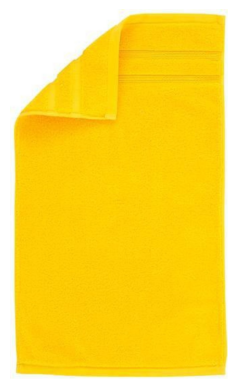

In [36]:
filename_2 = "526cb1e7675adb39a1ea68f1f2a3fd59.jpg"
image_path_2 = os.path.join(IMAGE_DIR, filename_2)
img_2 = cv2.imread(image_path_2)
img_rgb_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)  # Convertir BGR (OpenCV) → RGB (matplotlib)

plt.imshow(img_rgb_2)
plt.axis('off')  # Supprime les axes
plt.show()

In [37]:
for i, c in enumerate(['R', 'G', 'B']):
    channel = img_rgb_2[:, :, i]
    print(f"{c} min: {channel.min()}, max: {channel.max()}")


R min: 211, max: 255
G min: 146, max: 255
B min: 0, max: 255


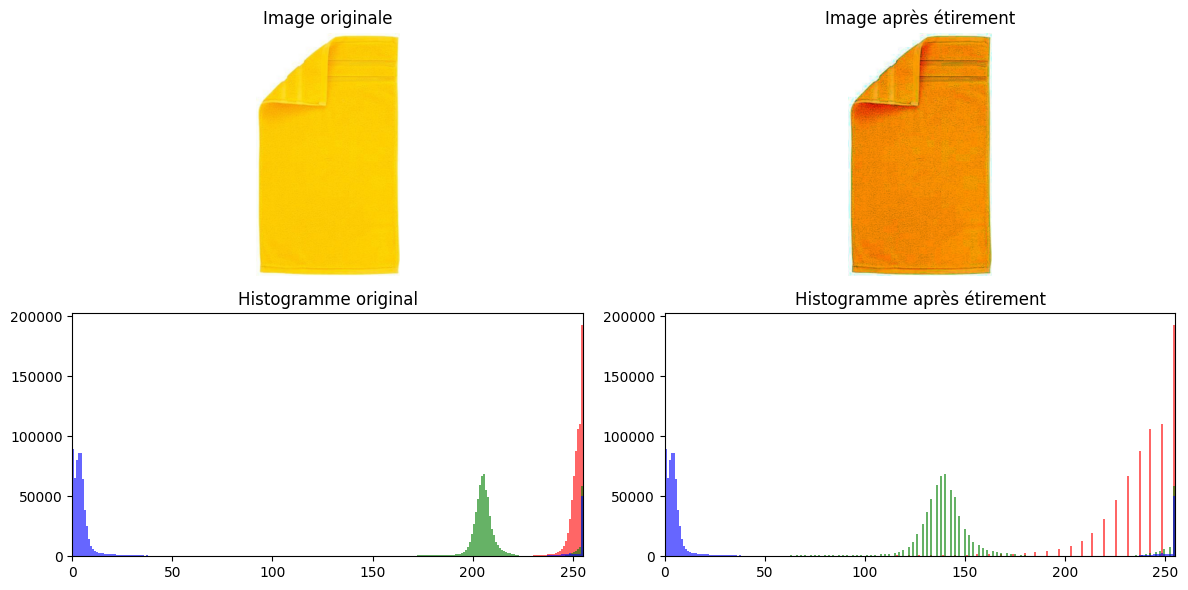

In [38]:
# 2. Étirement canal par canal
img_stretched = np.zeros_like(img_rgb_2)
for i in range(3):  # 0=R, 1=G, 2=B après conversion en RGB
    img_stretched[:, :, i] = cv2.normalize(img_rgb_2[:, :, i], None, 0, 255, cv2.NORM_MINMAX)

# 3. Tracer les images et histogrammes
colors = ('r', 'g', 'b')

fig, axs = plt.subplots(2, 2, figsize=(12, 6))

# Image originale
axs[0, 0].imshow(img_rgb_2)
axs[0, 0].set_title("Image originale")
axs[0, 0].axis('off')

# Histogramme original
axs[1, 0].set_title("Histogramme original")
for i, color in enumerate(colors):
    axs[1, 0].hist(img_rgb_2[:, :, i].ravel(), bins=256, color=color, alpha=0.6, range=(0, 255))
axs[1, 0].set_xlim([0, 255])

# Image étirée
axs[0, 1].imshow(img_stretched)
axs[0, 1].set_title("Image après étirement")
axs[0, 1].axis('off')

# Histogramme étiré
axs[1, 1].set_title("Histogramme après étirement")
for i, color in enumerate(colors):
    axs[1, 1].hist(img_stretched[:, :, i].ravel(), bins=256, color=color, alpha=0.6, range=(0, 255))
axs[1, 1].set_xlim([0, 255])

plt.tight_layout()
plt.show()

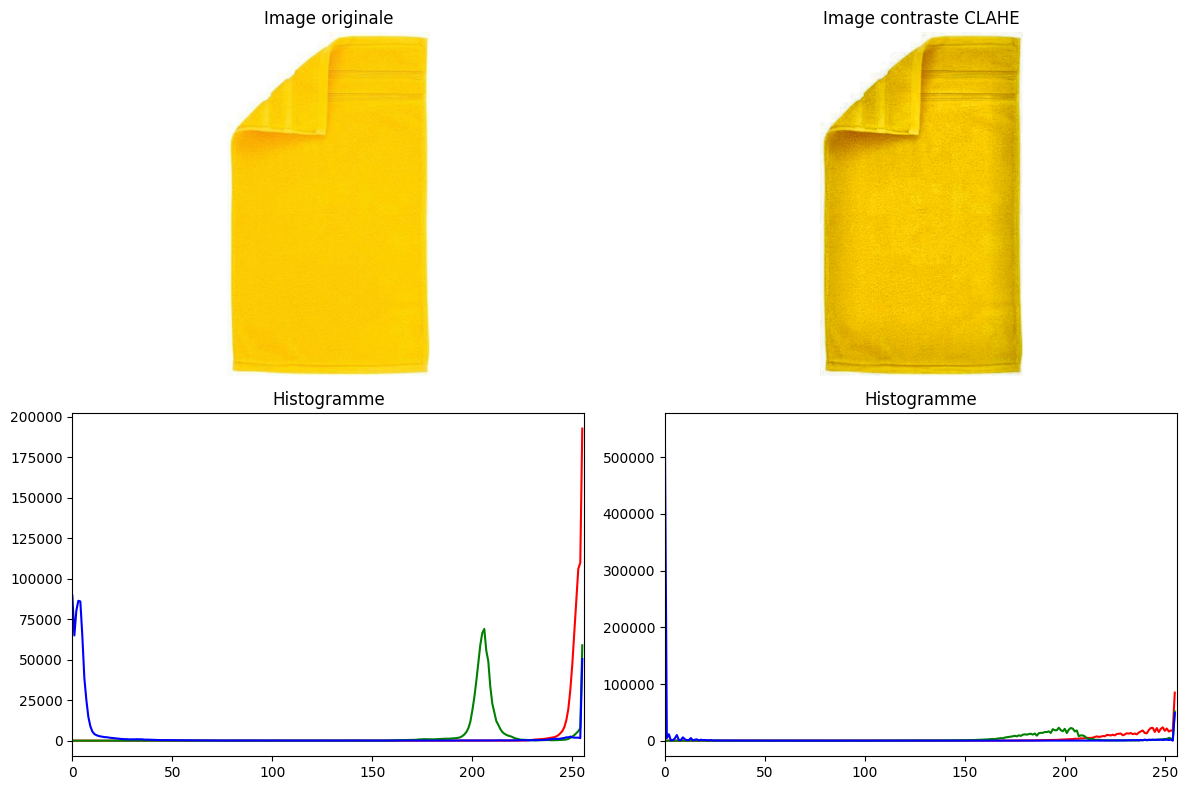

In [39]:
# Appliquer contraste
img_contrast = apply_contrast_clahe(img_2)

fig, axs = plt.subplots(2, 2, figsize=(12,8))

plot_image_and_histogram(img_2, axs[0,0], axs[1,0], "Image originale")
plot_image_and_histogram(img_contrast, axs[0,1], axs[1,1], "Image contraste CLAHE")

plt.tight_layout()
plt.show()

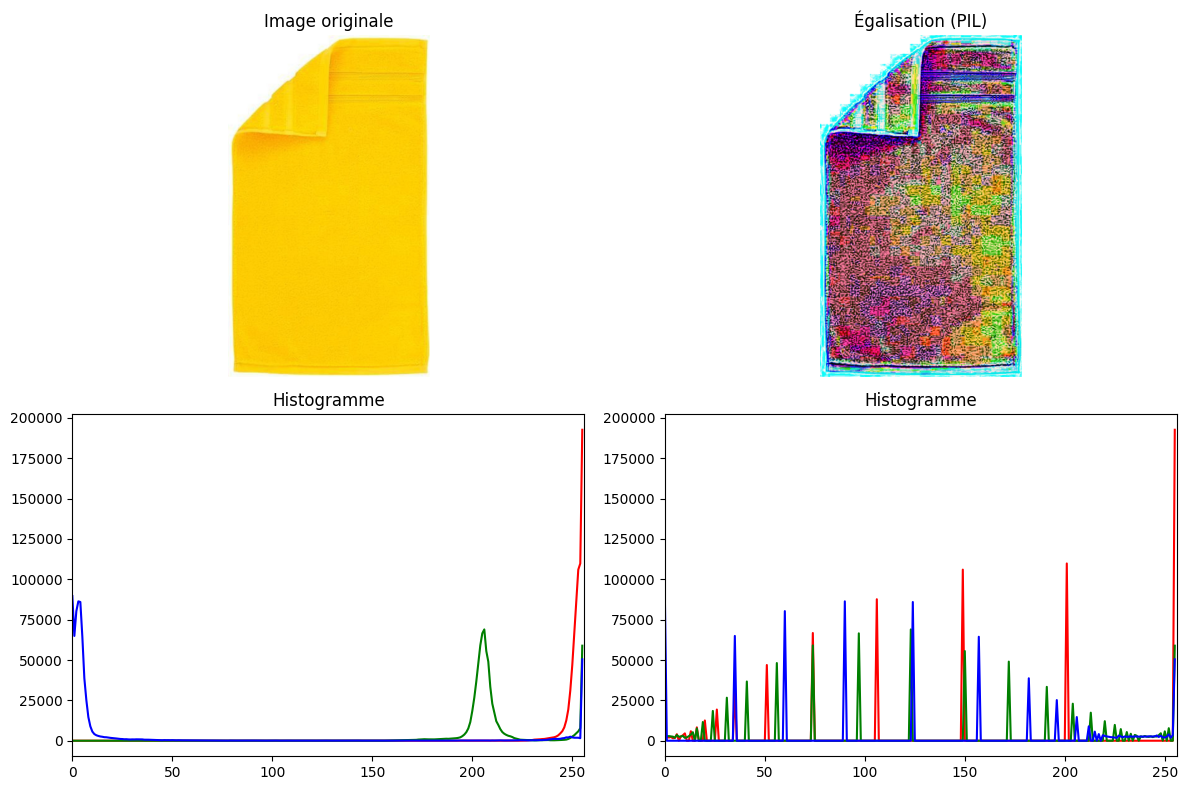

In [40]:
# Appliquer égalisation via PIL
img_equalized_pil = equalize_with_pil(img_2)

# OU bien : appliquer égalisation via OpenCV
# img_equalized_cv2 = equalize_with_cv2(img_original)

# --- Affichage côte à côte ---
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Colonne de gauche : image originale
plot_image_and_histogram(img_2, axs[0, 0], axs[1, 0], "Image originale")

# Colonne de droite : image égalisée
plot_image_and_histogram(img_equalized_pil, axs[0, 1], axs[1, 1], "Égalisation (PIL)")

# Si tu veux comparer avec OpenCV au lieu de PIL, remplace la ligne ci-dessus par :
# plot_image_and_histogram(img_equalized_cv2, axs[0, 1], axs[1, 1], "Égalisation (OpenCV)")

plt.tight_layout()
plt.show()


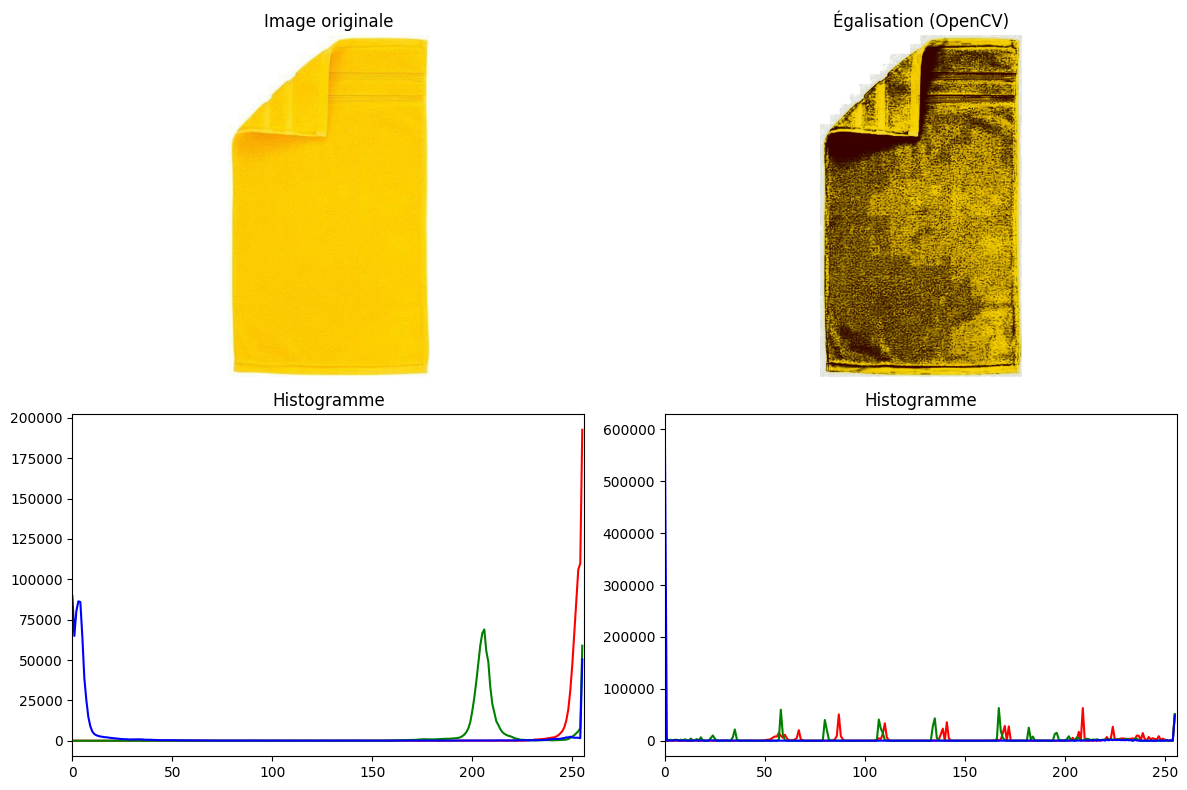

In [41]:
# Appliquer égalisation via PIL
# img_equalized_pil = equalize_with_pil(img_2)

# OU bien : appliquer égalisation via OpenCV
img_equalized_cv2 = equalize_with_cv2(img_2)

# --- Affichage côte à côte ---
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Colonne de gauche : image originale
plot_image_and_histogram(img_2, axs[0, 0], axs[1, 0], "Image originale")

# Colonne de droite : image égalisée
# plot_image_and_histogram(img_equalized_pil, axs[0, 1], axs[1, 1], "Égalisation (PIL)")

# Si tu veux comparer avec OpenCV au lieu de PIL, remplace la ligne ci-dessus par :
plot_image_and_histogram(img_equalized_cv2, axs[0, 1], axs[1, 1], "Égalisation (OpenCV)")

plt.tight_layout()
plt.show()


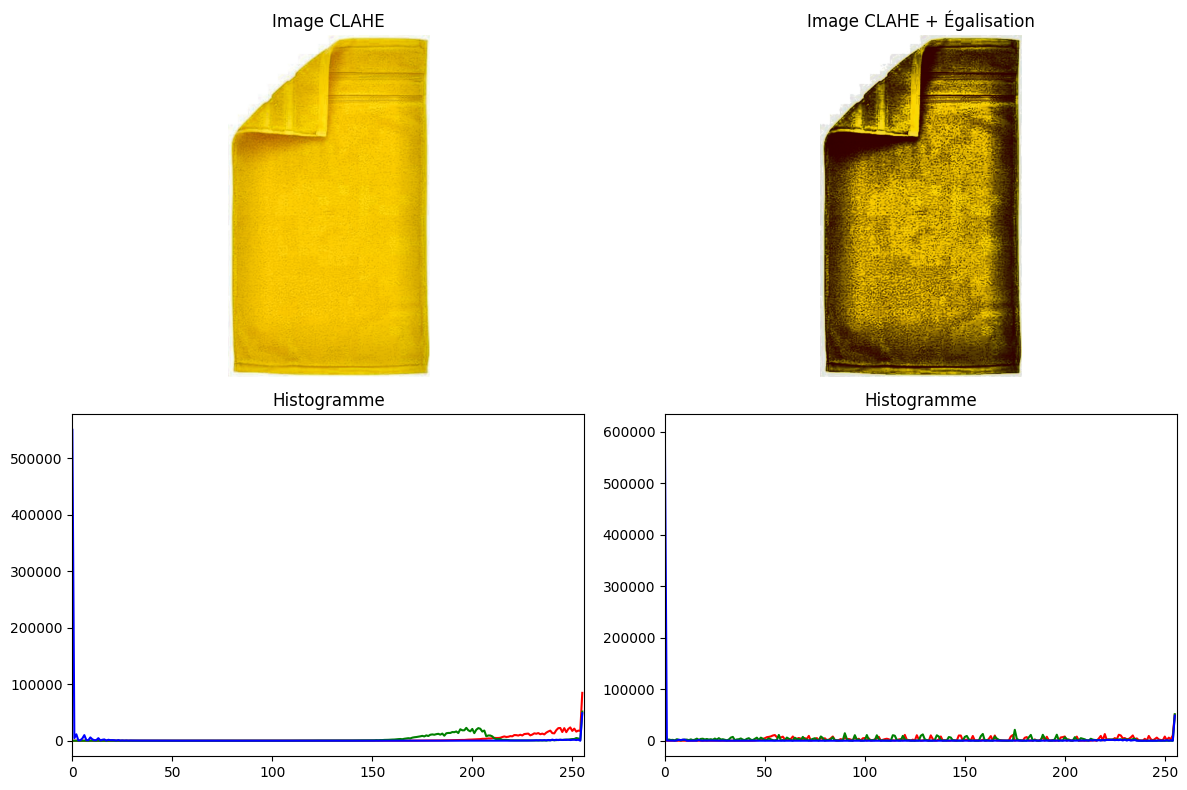

In [42]:
img_clahe = apply_contrast_clahe(img_2)
img_clahe_eq = equalize_hist_color(img_clahe)

fig, axs = plt.subplots(2, 2, figsize=(12,8))

plot_image_and_histogram(img_clahe, axs[0,0], axs[1,0], "Image CLAHE")
plot_image_and_histogram(img_clahe_eq, axs[0,1], axs[1,1], "Image CLAHE + Égalisation")

plt.tight_layout()
plt.show()

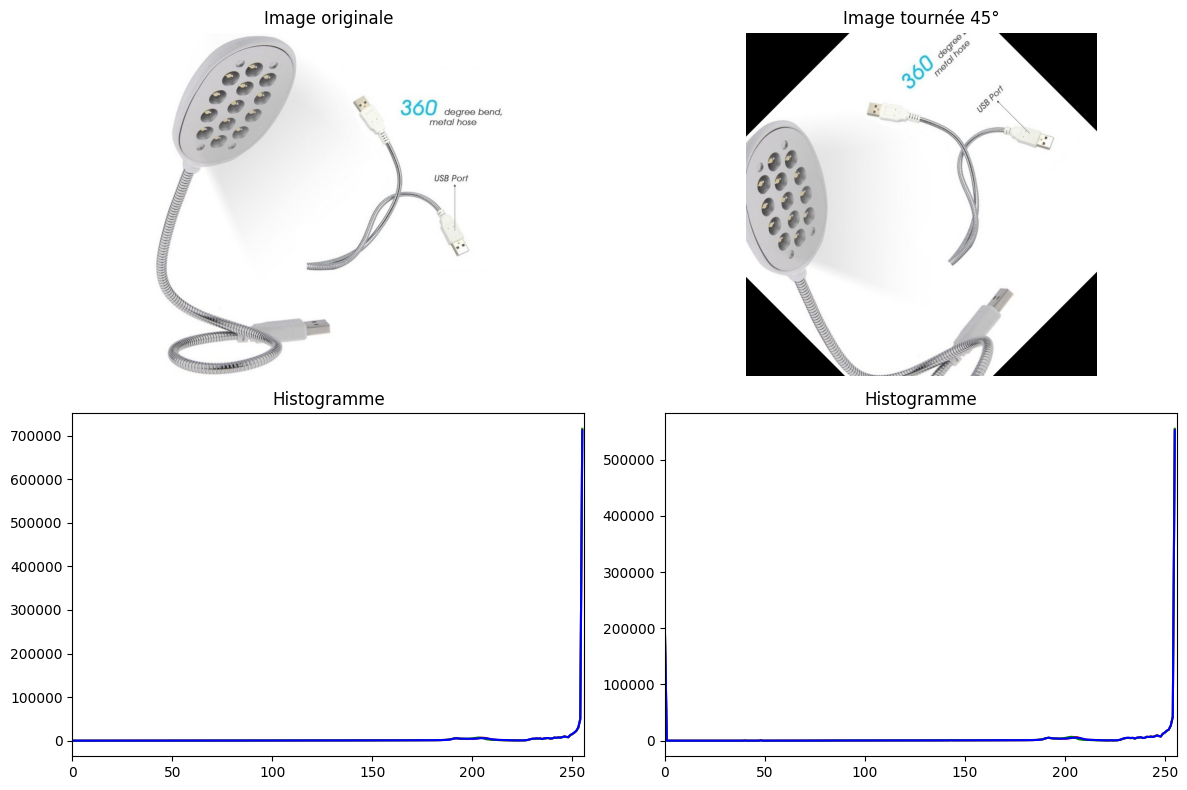

In [43]:
# Transformation géométrique : rotation de 45 degrés
img_rotated = rotate_image(img, 45)

fig, axs = plt.subplots(2, 2, figsize=(12,8))

plot_image_and_histogram(img, axs[0,0], axs[1,0], "Image originale")
plot_image_and_histogram(img_rotated, axs[0,1], axs[1,1], "Image tournée 45°")

plt.tight_layout()
plt.show()

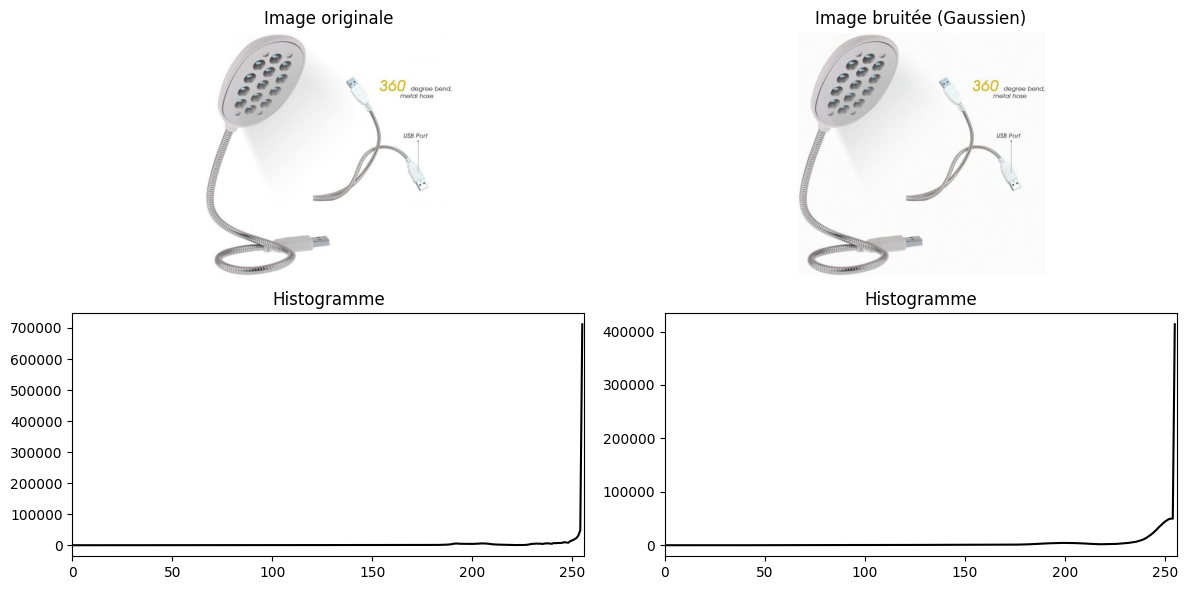

In [44]:
# Générer du bruit gaussien (moyenne = 0, std = 7)
noise = np.random.normal(0, 7, img.shape)

# Ajouter le bruit, clipper entre 0 et 255 et convertir en uint8
noisy_img = np.clip(img + noise, 0, 255).astype(np.uint8)

# Affichage côte à côte
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

plot_gray_image_and_histogram(img, axs[0, 0], axs[1, 0], "Image originale")
plot_gray_image_and_histogram(noisy_img, axs[0, 1], axs[1, 1], "Image bruitée (Gaussien)")

plt.tight_layout()
plt.show()

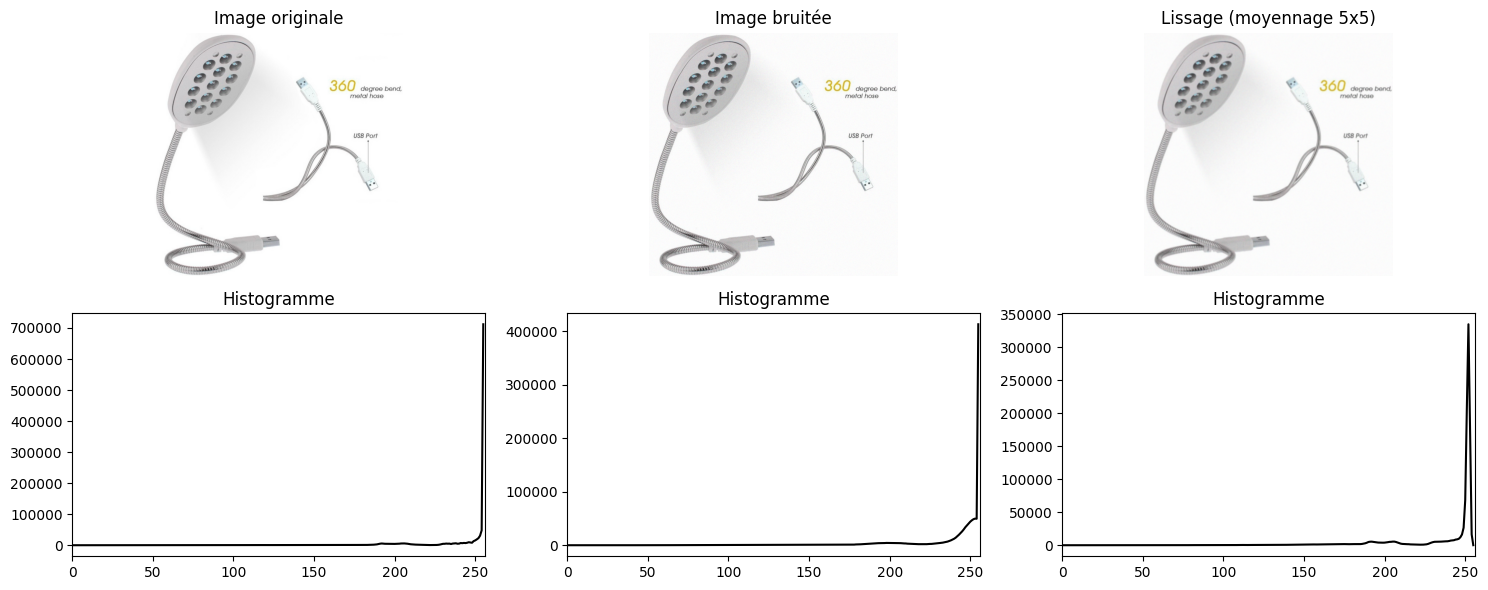

In [45]:
# Ajouter du bruit gaussien
noise = np.random.normal(0, 7, img.shape)
noisy_img = np.clip(img + noise, 0, 255).astype(np.uint8)

# Appliquer un lissage par moyennage (filtre 5x5 par exemple)
smoothed_img = cv2.blur(noisy_img, (5, 5))

# Affichage côte à côte
fig, axs = plt.subplots(2, 3, figsize=(15, 6))

# Image originale
plot_gray_image_and_histogram(img, axs[0, 0], axs[1, 0], "Image originale")

# Image bruitée
plot_gray_image_and_histogram(noisy_img, axs[0, 1], axs[1, 1], "Image bruitée")

# Image lissée
plot_gray_image_and_histogram(smoothed_img, axs[0, 2], axs[1, 2], "Lissage (moyennage 5x5)")

plt.tight_layout()
plt.show()

<h2 style="text-align: left; font-weight: bold;"><u>Extraction de features</u></h2>


⏳ Extraction ORB...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1050/1050 [01:16<00:00, 13.81it/s]



🔍 Méthode : ORB
🎯 ARI (ORB): 0.0261


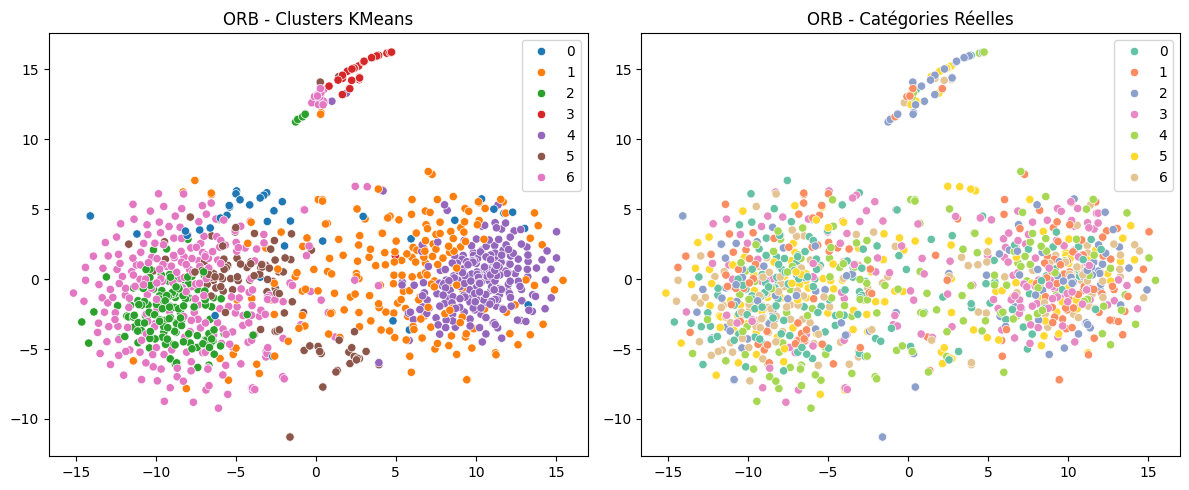


⏳ Extraction CNN (ResNet50)...


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 677/1050 [04:32<02:28,  2.51it/s]C:\Users\david\AppData\Local\pypoetry\Cache\virtualenvs\classifier-automatiquement-des-biens-de-co-6WHE6-ry-py3.10\lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1050/1050 [06:58<00:00,  2.51it/s]



🔍 Méthode : CNN (ResNet50)
🎯 ARI (CNN (ResNet50)): 0.4891


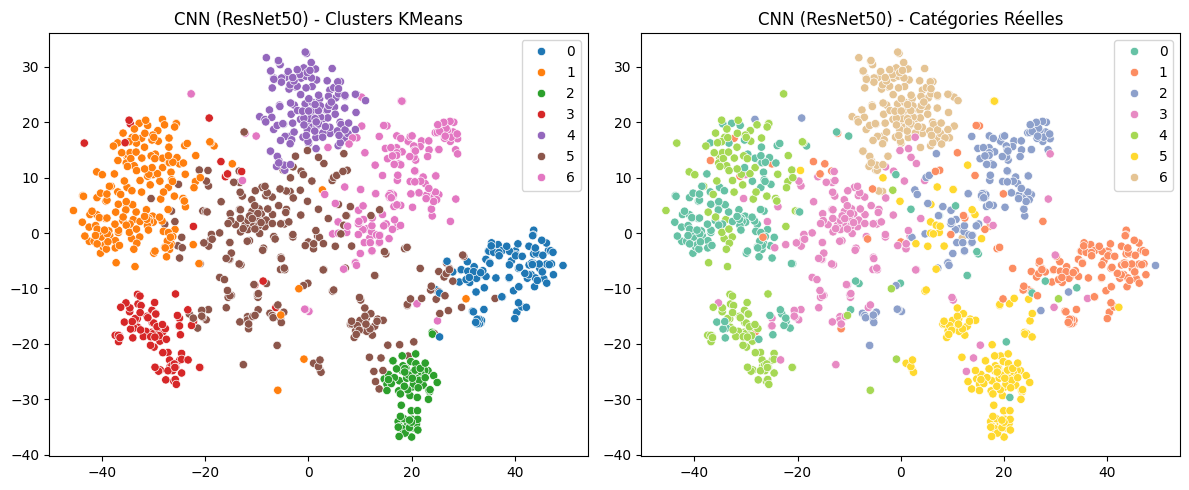


📈 Résultats comparatifs :
          Méthode       ARI
1  CNN (ResNet50)  0.489074
0             ORB  0.026097


In [46]:
results2  = run_all_methods2(df)


⏳ Extraction SIFT...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1050/1050 [17:58<00:00,  1.03s/it]



🔍 Méthode : SIFT
🎯 ARI (SIFT): 0.0431


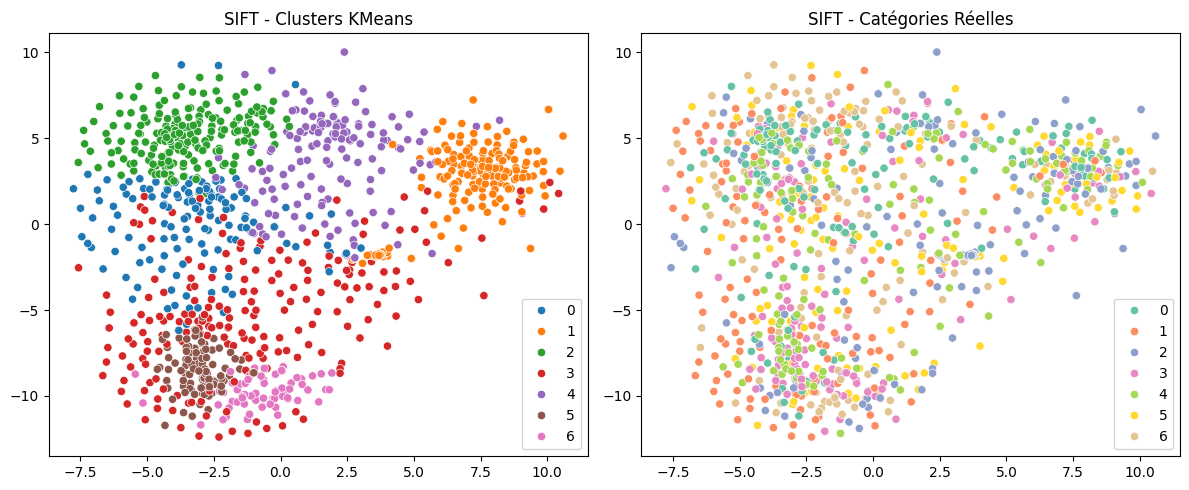


📈 Résultats comparatifs :
  Méthode       ARI
0    SIFT  0.043106


In [49]:
results1 = run_all_methods(df)

In [50]:
# Optionnel : concaténer et sauvegarder
final_results = pd.concat([results1, results2], ignore_index=True)
final_results.to_csv("ari_results.csv", index=False)

<h2 style="text-align: left; font-weight: bold;"><u>Classification supervisée à partir des images</u></h2>

Found 840 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.

🔧 Entraînement du modèle VGG16...


C:\Users\david\AppData\Local\pypoetry\Cache\virtualenvs\classifier-automatiquement-des-biens-de-co-6WHE6-ry-py3.10\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
 6/27 ━━━━━━━━━━━━━━━━━━━━ 2:15 6s/step - accuracy: 0.1093 - loss: 2.1681

C:\Users\david\AppData\Local\pypoetry\Cache\virtualenvs\classifier-automatiquement-des-biens-de-co-6WHE6-ry-py3.10\lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


27/27 ━━━━━━━━━━━━━━━━━━━━ 213s 8s/step - accuracy: 0.1552 - loss: 2.1065 - val_accuracy: 0.2619 - val_loss: 1.8935
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 263s 8s/step - accuracy: 0.2050 - loss: 1.9753 - val_accuracy: 0.3905 - val_loss: 1.8332
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 213s 8s/step - accuracy: 0.2075 - loss: 1.8988 - val_accuracy: 0.4000 - val_loss: 1.7920
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 213s 8s/step - accuracy: 0.2627 - loss: 1.8538 - val_accuracy: 0.4286 - val_loss: 1.7531
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 13535s 520s/step - accuracy: 0.3096 - loss: 1.8009 - val_accuracy: 0.4429 - val_loss: 1.7159
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 209s 8s/step - accuracy: 0.3509 - loss: 1.7429 - val_accuracy: 0.5381 - val_loss: 1.6753
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 210s 8s/step - accuracy: 0.3564 - loss: 1.7479 - val_accuracy: 0.5524 - val_loss: 1.6389
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 209s 8s/step - accuracy: 0.4242 - loss: 1.6951 - val_accuracy: 0.5857 - val_loss

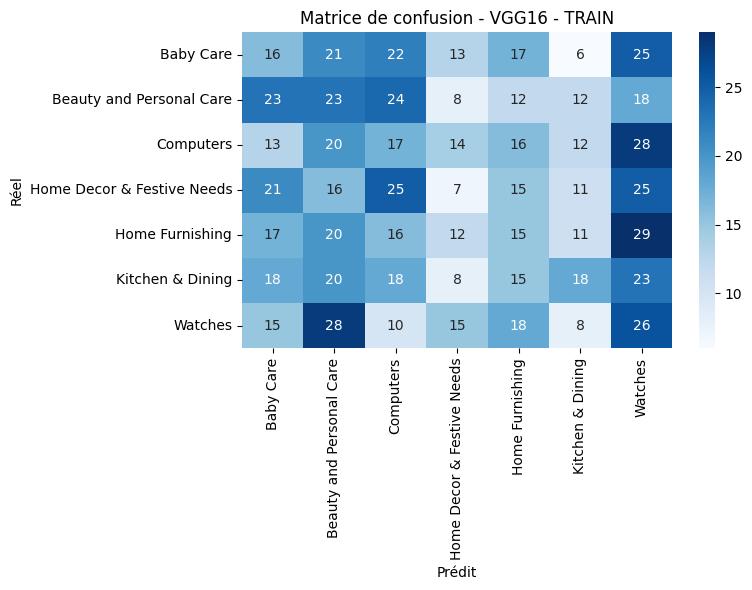


📊 Rapport de classification - VGG16 - TRAIN
                            precision    recall  f1-score   support

                 Baby Care       0.13      0.13      0.13       120
  Beauty and Personal Care       0.16      0.19      0.17       120
                 Computers       0.13      0.14      0.13       120
Home Decor & Festive Needs       0.09      0.06      0.07       120
           Home Furnishing       0.14      0.12      0.13       120
          Kitchen & Dining       0.23      0.15      0.18       120
                   Watches       0.15      0.22      0.18       120

                  accuracy                           0.15       840
                 macro avg       0.15      0.15      0.14       840
              weighted avg       0.15      0.15      0.14       840

7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step


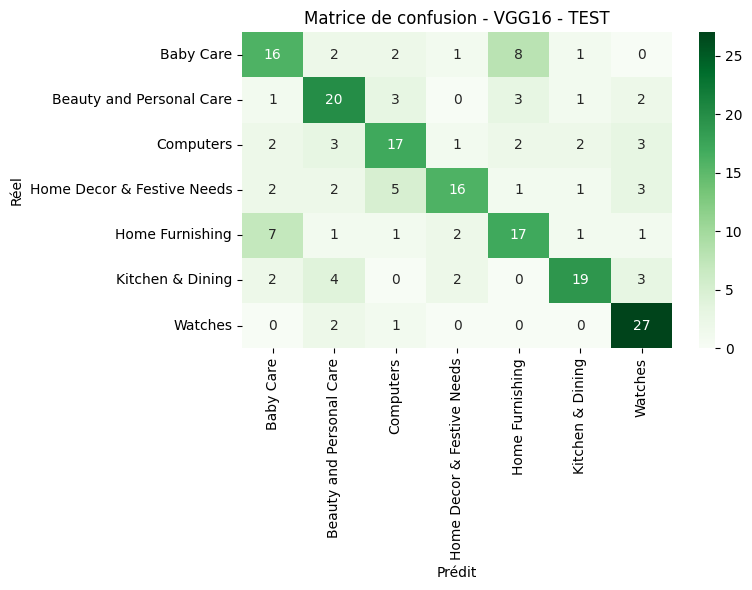


📊 Rapport de classification - VGG16 - TEST
                            precision    recall  f1-score   support

                 Baby Care       0.53      0.53      0.53        30
  Beauty and Personal Care       0.59      0.67      0.62        30
                 Computers       0.59      0.57      0.58        30
Home Decor & Festive Needs       0.73      0.53      0.62        30
           Home Furnishing       0.55      0.57      0.56        30
          Kitchen & Dining       0.76      0.63      0.69        30
                   Watches       0.69      0.90      0.78        30

                  accuracy                           0.63       210
                 macro avg       0.63      0.63      0.63       210
              weighted avg       0.63      0.63      0.63       210



In [19]:
# 📁 Paramètres
image_dir = "data/images"  # Remplace par le chemin réel
input_shape = (224, 224, 3)
batch_size = 32
epochs = 10

# 🧾 Chargement de ton DataFrame (déjà en mémoire dans df)
df, le = prepare_dataframe(df, image_dir)
train_gen, test_gen, df_train, df_test = create_data_generators(df, input_shape, batch_size)
num_classes = len(le.classes_)

# 🧠 Entraînement et évaluation des 3 modèles
model_vgg = train_and_evaluate_model(VGG16, "VGG16", train_gen, test_gen, input_shape, num_classes, le, epochs)

C:\Users\david\AppData\Local\pypoetry\Cache\virtualenvs\classifier-automatiquement-des-biens-de-co-6WHE6-ry-py3.10\lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


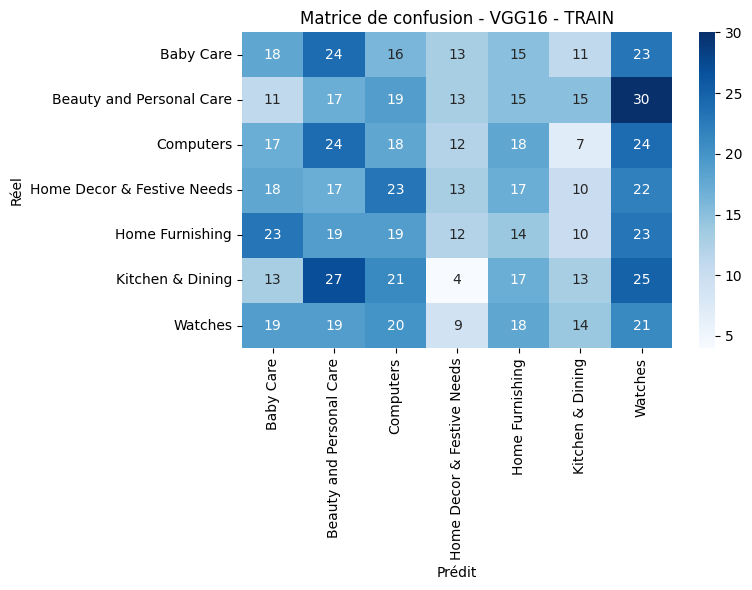


🧾 Rapport de classification - VGG16 - TRAIN :

                            precision    recall  f1-score   support

                 Baby Care       0.15      0.15      0.15       120
  Beauty and Personal Care       0.12      0.14      0.13       120
                 Computers       0.13      0.15      0.14       120
Home Decor & Festive Needs       0.17      0.11      0.13       120
           Home Furnishing       0.12      0.12      0.12       120
          Kitchen & Dining       0.16      0.11      0.13       120
                   Watches       0.12      0.17      0.15       120

                  accuracy                           0.14       840
                 macro avg       0.14      0.14      0.14       840
              weighted avg       0.14      0.14      0.14       840



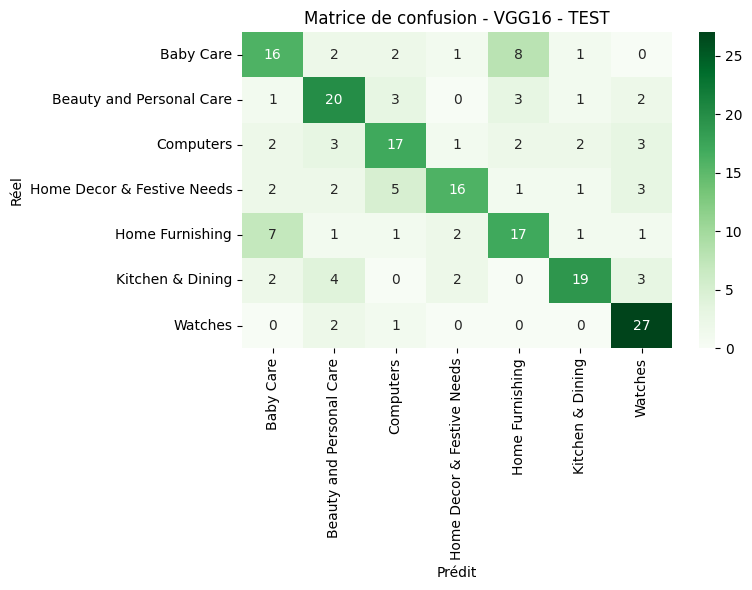


🧾 Rapport de classification - VGG16 - TEST :

                            precision    recall  f1-score   support

                 Baby Care       0.53      0.53      0.53        30
  Beauty and Personal Care       0.59      0.67      0.62        30
                 Computers       0.59      0.57      0.58        30
Home Decor & Festive Needs       0.73      0.53      0.62        30
           Home Furnishing       0.55      0.57      0.56        30
          Kitchen & Dining       0.76      0.63      0.69        30
                   Watches       0.69      0.90      0.78        30

                  accuracy                           0.63       210
                 macro avg       0.63      0.63      0.63       210
              weighted avg       0.63      0.63      0.63       210



In [ ]:
evaluate_model_2(model_vgg, train_gen, le, "VGG16 - TRAIN", "Blues")
evaluate_model_2(model_vgg, test_gen, le, "VGG16 - TEST", "Greens")


🔧 Entraînement du modèle ResNet50...
Epoch 1/10
14/27 ━━━━━━━━━━━━━━━━━━━━ 11s 855ms/step - accuracy: 0.1400 - loss: 2.5540

C:\Users\david\AppData\Local\pypoetry\Cache\virtualenvs\classifier-automatiquement-des-biens-de-co-6WHE6-ry-py3.10\lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


27/27 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.1379 - loss: 2.4744 - val_accuracy: 0.1238 - val_loss: 1.9582
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.1742 - loss: 2.0890 - val_accuracy: 0.1714 - val_loss: 1.9328
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.1715 - loss: 2.1316 - val_accuracy: 0.1905 - val_loss: 1.9243
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.1674 - loss: 2.0464 - val_accuracy: 0.2000 - val_loss: 1.9119
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.1677 - loss: 2.0031 - val_accuracy: 0.1905 - val_loss: 1.9072
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.1757 - loss: 1.9934 - val_accuracy: 0.2048 - val_loss: 1.8998
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.1777 - loss: 1.9908 - val_accuracy: 0.2286 - val_loss: 1.8923
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.1960 - loss: 1.9460 - val_accuracy: 0.2571 - val_loss: 1.8884
Epo

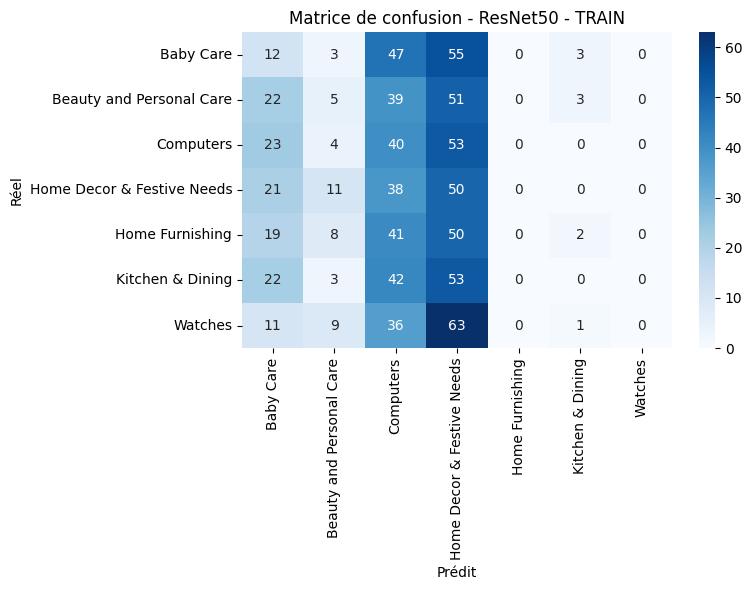


📊 Rapport de classification - ResNet50 - TRAIN
                            precision    recall  f1-score   support

                 Baby Care       0.09      0.10      0.10       120
  Beauty and Personal Care       0.12      0.04      0.06       120
                 Computers       0.14      0.33      0.20       120
Home Decor & Festive Needs       0.13      0.42      0.20       120
           Home Furnishing       0.00      0.00      0.00       120
          Kitchen & Dining       0.00      0.00      0.00       120
                   Watches       0.00      0.00      0.00       120

                  accuracy                           0.13       840
                 macro avg       0.07      0.13      0.08       840
              weighted avg       0.07      0.13      0.08       840



C:\Users\david\AppData\Local\pypoetry\Cache\virtualenvs\classifier-automatiquement-des-biens-de-co-6WHE6-ry-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\david\AppData\Local\pypoetry\Cache\virtualenvs\classifier-automatiquement-des-biens-de-co-6WHE6-ry-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\david\AppData\Local\pypoetry\Cache\virtualenvs\classifier-automatiquement-des-biens-de-co-6WHE6-ry-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1706

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step   


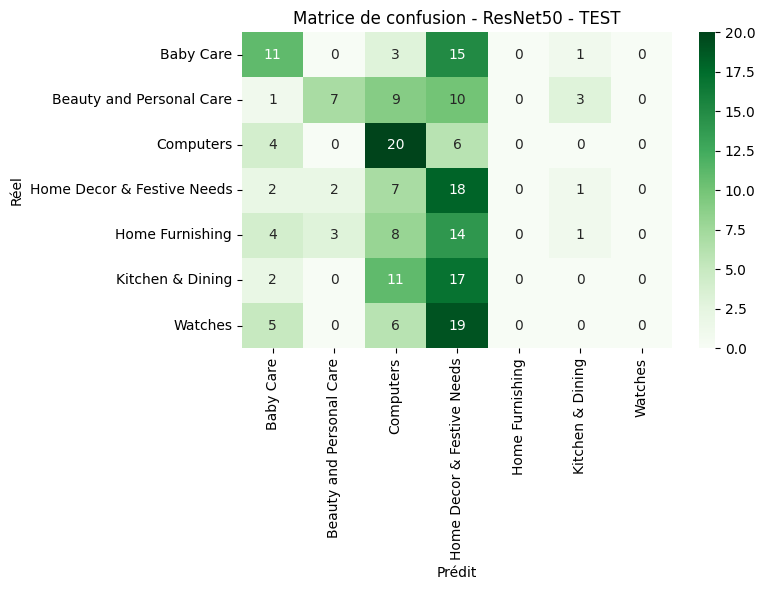


📊 Rapport de classification - ResNet50 - TEST
                            precision    recall  f1-score   support

                 Baby Care       0.38      0.37      0.37        30
  Beauty and Personal Care       0.58      0.23      0.33        30
                 Computers       0.31      0.67      0.43        30
Home Decor & Festive Needs       0.18      0.60      0.28        30
           Home Furnishing       0.00      0.00      0.00        30
          Kitchen & Dining       0.00      0.00      0.00        30
                   Watches       0.00      0.00      0.00        30

                  accuracy                           0.27       210
                 macro avg       0.21      0.27      0.20       210
              weighted avg       0.21      0.27      0.20       210


🔧 Entraînement du modèle MobileNetV2...


C:\Users\david\AppData\Local\pypoetry\Cache\virtualenvs\classifier-automatiquement-des-biens-de-co-6WHE6-ry-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\david\AppData\Local\pypoetry\Cache\virtualenvs\classifier-automatiquement-des-biens-de-co-6WHE6-ry-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\david\AppData\Local\pypoetry\Cache\virtualenvs\classifier-automatiquement-des-biens-de-co-6WHE6-ry-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1706

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
 2/27 ━━━━━━━━━━━━━━━━━━━━ 11s 452ms/step - accuracy: 0.2109 - loss: 2.5175

C:\Users\david\AppData\Local\pypoetry\Cache\virtualenvs\classifier-automatiquement-des-biens-de-co-6WHE6-ry-py3.10\lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 651ms/step - accuracy: 0.2113 - loss: 2.3236 - val_accuracy: 0.4190 - val_loss: 1.5924
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 624ms/step - accuracy: 0.3132 - loss: 1.7717 - val_accuracy: 0.6095 - val_loss: 1.2572
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 636ms/step - accuracy: 0.5241 - loss: 1.3854 - val_accuracy: 0.6952 - val_loss: 1.0369
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 702ms/step - accuracy: 0.6084 - loss: 1.2285 - val_accuracy: 0.7238 - val_loss: 0.8928
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 614ms/step - accuracy: 0.6787 - loss: 1.0221 - val_accuracy: 0.7619 - val_loss: 0.7833
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 652ms/step - accuracy: 0.6828 - loss: 0.9655 - val_accuracy: 0.7857 - val_loss: 0.7197
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.7275 - loss: 0.8270 - val_accuracy: 0.8000 - val_loss: 0.6641
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7412 - loss: 0.8703 - val_accuracy: 0.8238 - va

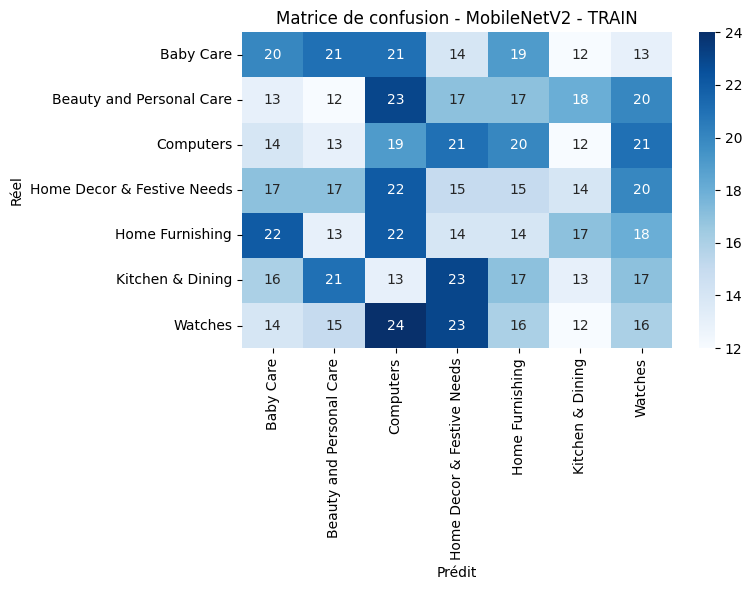


📊 Rapport de classification - MobileNetV2 - TRAIN
                            precision    recall  f1-score   support

                 Baby Care       0.17      0.17      0.17       120
  Beauty and Personal Care       0.11      0.10      0.10       120
                 Computers       0.13      0.16      0.14       120
Home Decor & Festive Needs       0.12      0.12      0.12       120
           Home Furnishing       0.12      0.12      0.12       120
          Kitchen & Dining       0.13      0.11      0.12       120
                   Watches       0.13      0.13      0.13       120

                  accuracy                           0.13       840
                 macro avg       0.13      0.13      0.13       840
              weighted avg       0.13      0.13      0.13       840

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 356ms/step


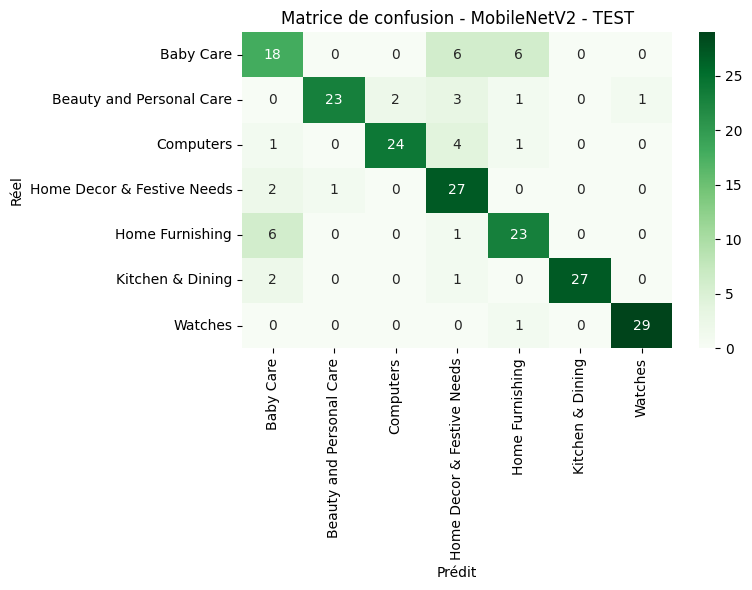


📊 Rapport de classification - MobileNetV2 - TEST
                            precision    recall  f1-score   support

                 Baby Care       0.62      0.60      0.61        30
  Beauty and Personal Care       0.96      0.77      0.85        30
                 Computers       0.92      0.80      0.86        30
Home Decor & Festive Needs       0.64      0.90      0.75        30
           Home Furnishing       0.72      0.77      0.74        30
          Kitchen & Dining       1.00      0.90      0.95        30
                   Watches       0.97      0.97      0.97        30

                  accuracy                           0.81       210
                 macro avg       0.83      0.81      0.82       210
              weighted avg       0.83      0.81      0.82       210



In [ ]:
model_resnet = train_and_evaluate_model(ResNet50, "ResNet50", train_gen, test_gen, input_shape, num_classes, le, epochs)
model_mobile = train_and_evaluate_model(MobileNetV2, "MobileNetV2", train_gen, test_gen, input_shape, num_classes, le, epochs)